In [1]:
import pandas as pd
import geopandas
import json
import os
from shapely.geometry import Point
import difflib
from geopy.distance import vincenty
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
inline_rc = dict(mpl.rcParams)

In [2]:
#in_folder = "audits/2018_07/data/"
out_folder = "audits/2019_05/images/"
in_folder = "../data/"
#out_folder = "/tmp"

Fichier des tracés:
    https://opendata.stif.info/explore/dataset/bus_lignes/export/
    
Fichier pour faire la correspondance :
    https://opendata.stif.info/explore/dataset/referentiel-des-lignes-stif/export/

In [3]:
opendata_ref = pd.read_csv("ref_data/referentiel-des-lignes-stif.csv",delimiter=";")
#opendata_ref

In [4]:
gtfs_lines = pd.read_csv(os.path.join(in_folder, "gtfs_routes.txt"), dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

In [5]:
opendata_tracks = pd.read_csv("ref_data/bus_lignes.csv",delimiter=";")

opendata_tracks.dropna(inplace=True)
opendata_tracks.drop_duplicates('ID_GroupOfLines',inplace=True)

opendata_tracks = opendata_tracks.merge(opendata_ref, how='inner', on='ID_GroupOfLines')

opendata_tracks = opendata_tracks[['Geo Shape', 'ShortName_Line', 'TransportMode', 'NetworkName', 'ExternalCode_Line' ]]

opendata_tracks = opendata_tracks[opendata_tracks['TransportMode']=='bus']
#opendata_tracks.head()

In [6]:
# on prépare les tracés pour analyse
from functools import partial
import pyproj
from shapely import wkt
from shapely.geometry import shape
from shapely.ops import transform

project = partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(init='EPSG:2154'))

def geojson_to_wkt(row):
    if pd.isna(row['Geo Shape']):
        wkt_ = wkt.loads('POINT (2.482068 49.0327237)')
    else :     
        wkt_ = shape(json.loads(row['Geo Shape']))
    return transform(project, wkt_) # on projette, pour avoir plus tard la longueur en mètres

opendata_tracks['geom'] = opendata_tracks.apply(geojson_to_wkt, axis=1)
opendata_lines_geo = geopandas.GeoDataFrame(opendata_tracks, geometry=opendata_tracks.geom)
#opendata_lines_geo

In [7]:
#opendata_lines_geo.plot()
# TODO : graphique aussi sur OSM pour montrer qu'encore une fois, c'est en périphérie que ça manque

In [8]:
opendata_lines_geo['line_length'] = opendata_lines_geo.length/1000
opendata_lines_geo[['line_length', 'ShortName_Line','NetworkName', 'TransportMode', 'ExternalCode_Line','geom' ]]

print("Nombre de lignes avec tracé : {}".format(len(opendata_lines_geo)))

tt = len(opendata_lines_geo) * 100.0 / len(gtfs_lines)
"Pourcentage de lignes qui ont un tracé : {}".format(tt)

Nombre de lignes avec tracé : 1709


'Pourcentage de lignes qui ont un tracé : 89.24281984334203'

In [9]:
# TODO regarder les lignes GTFS sans tracés pour voir si on les a dans OSM ?

## OSM

In [10]:
osm_lines = pd.read_csv(os.path.join(in_folder, "osm-transit-extractor_lines.csv"), dtype=str)
osm_lines = osm_lines[osm_lines['mode'] == 'bus']


osm_lines = osm_lines[['line_id', 'name', 'osm:ref:FR:STIF:ExternalCode_Line','code', 'colour', 'operator', 'network','shape']].copy()
#osm_lines.head()

In [11]:
def osm_shape_to_wkt(row):
    if pd.isna(row['shape']):
        wkt_ = wkt.loads('POINT (2.482068 49.0327237)')
    else :
        wkt_ = wkt.loads(row['shape'])
    return transform(project, wkt_) # on projette, pour avoir plus tard la longueur en mètres

osm_lines['geom'] = osm_lines.apply(osm_shape_to_wkt, axis=1)
osm_lines_geo = geopandas.GeoDataFrame(osm_lines, geometry=osm_lines.geom)


In [12]:
#osm_lines_geo.plot()

In [13]:
osm_lines_geo['line_length'] = (osm_lines_geo.length ) /1000
osm_lines_geo_ok = osm_lines_geo[osm_lines_geo['line_length'] >= 0.2].copy() 
osm_lines_geo_ok[['line_id', 'name', 'network','osm:ref:FR:STIF:ExternalCode_Line', 'line_length']]

print("Nombre de lignes avec tracé : {}".format(len(osm_lines_geo_ok)))

tt = len(osm_lines_geo_ok) * 100.0 / len(osm_lines_geo)
"Pourcentage des lignes d'OSM qui ont un tracé : {}".format(tt)

Nombre de lignes avec tracé : 905


"Pourcentage des lignes d'OSM qui ont un tracé : 67.73952095808383"

/home/pclf/.local/share/virtualenvs/audit_routepoints-xp16w_6c/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pclf/.local/share/virtualenvs/audit_routepoints-xp16w_6c/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


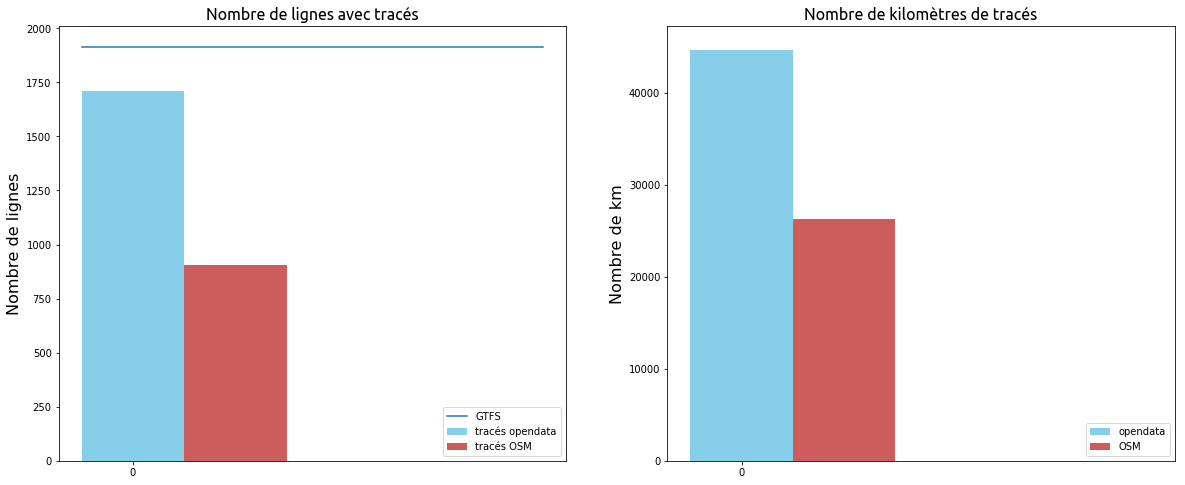

In [14]:
mpl.rcParams.update(inline_rc) # reset du style 

width = 0.5
ind = np.arange(1)

#fig, ax = plt.subplots(figsize=(6, 8))
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(121)

ax.bar(ind , [len(opendata_lines_geo)],width/4,  color='SkyBlue', label='tracés opendata')
ax.bar(ind + width/4, [len(osm_lines_geo_ok)], width/4, color='IndianRed', label='tracés OSM')
ax.plot([ind - width/8, ind + width/4, ind + width], [len(gtfs_lines),len(gtfs_lines),len(gtfs_lines) ], label="GTFS")
ax.set_xticks(ind)
ax.set_title('Nombre de lignes avec tracés', 
             fontname='Ubuntu', fontsize=16,
             fontstyle='normal', fontweight='normal')
ax.set_ylabel('Nombre de lignes', fontsize=16)
ax.legend()
ax.legend(loc="lower right")

ax = fig.add_subplot(122)
ax.bar(ind , [opendata_lines_geo['line_length'].sum()],width/4,  color='SkyBlue', label='opendata')
ax.bar(ind + width/4, [osm_lines_geo_ok['line_length'].sum()], width/4, color='IndianRed', label='OSM')
ax.plot([ind - width/8, ind + width/4, ind + width], [45000,45000,45000], color="white")

ax.set_xticks(ind)
ax.set_title('Nombre de kilomètres de tracés', 
             fontname='Ubuntu', fontsize=16,
             fontstyle='normal', fontweight='normal')
ax.set_ylabel('Nombre de km', fontsize=16)
ax.legend()
ax.legend(loc="lower right")

plt.savefig(os.path.join(out_folder,'20_traces_de_lignes.png'), bbox_inches='tight')

In [15]:
tt = opendata_lines_geo['line_length'].sum()
print("Nb de km de lignes dans l'opendata: {}".format(tt))

tt = osm_lines_geo_ok['line_length'].sum()
print("Nb de km de lignes dans OSM: {}".format(tt))

Nb de km de lignes dans l'opendata: 44616.0409130414
Nb de km de lignes dans OSM: 26290.434320460015


In [16]:
#osm_lines_geo_ok.groupby(['network'])['line_length'].sum()

# On fusionne pour faire des comparaisons

In [17]:
for c in opendata_lines_geo.columns:
    new_col = "opendata_" + c
    opendata_lines_geo.rename(columns={c: new_col}, inplace=True)
for c in osm_lines_geo_ok.columns:
    new_col = "osm_" + c
    osm_lines_geo_ok.rename(columns={c: new_col}, inplace=True)

In [18]:
lines_geo = opendata_lines_geo.merge(osm_lines_geo_ok, how='inner', right_on='osm_osm:ref:FR:STIF:ExternalCode_Line', left_on='opendata_ExternalCode_Line')
lines_geo[lines_geo['osm_network']=='Comète'][["opendata_line_length", "osm_line_length", "osm_code"]]

,opendata_line_length,osm_line_length,osm_code
167,92.681376,125.225597,202
178,13.754221,20.199307,203
222,47.532029,116.692044,210
225,12.630659,24.162391,204
226,38.560935,54.653729,208
354,16.124264,36.348489,209
416,19.747222,35.764831,201
639,3.269919,7.612733,205
769,41.219416,76.461909,206


In [19]:
networks_km = pd.DataFrame(lines_geo.groupby(['osm_network'])['osm_line_length', 'opendata_line_length'].sum()).reset_index()

#networks_km

In [20]:
len(networks_km[networks_km['osm_line_length']>=networks_km['opendata_line_length']])
## TODO : à creuser : j'ai plus de lignes où OSM a plus de km que l'opendata O_o 
# ou alors c'est parce qu'on a l'aller et le retour dans OSM et qu'un seul tracé simplifié dans l'opendata ?
# à vérifier avec QGIS

# c'est crédible
# voir par exemple la boucle vers le Centre Commercial Claye
#https://ref-lignes-stif.5apps.com/line.html?osm_relation=7728377

69

In [21]:
osm_better = networks_km[networks_km['osm_line_length']>=networks_km['opendata_line_length']]
osm_better.head()

,osm_network,osm_line_length,opendata_line_length
0,Albatrans,626.656862,316.375122
1,Apolo 7,205.981538,162.675704
3,Athis Cars,79.299673,65.979457
5,Autobus du Fort,18.342590,16.049367
7,BrieBus,16.516605,9.720349
